In [1]:
# imports 

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:00<00:00, 15988321.42it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 470035.60it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:00<00:00, 4414400.64it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 4234391.81it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



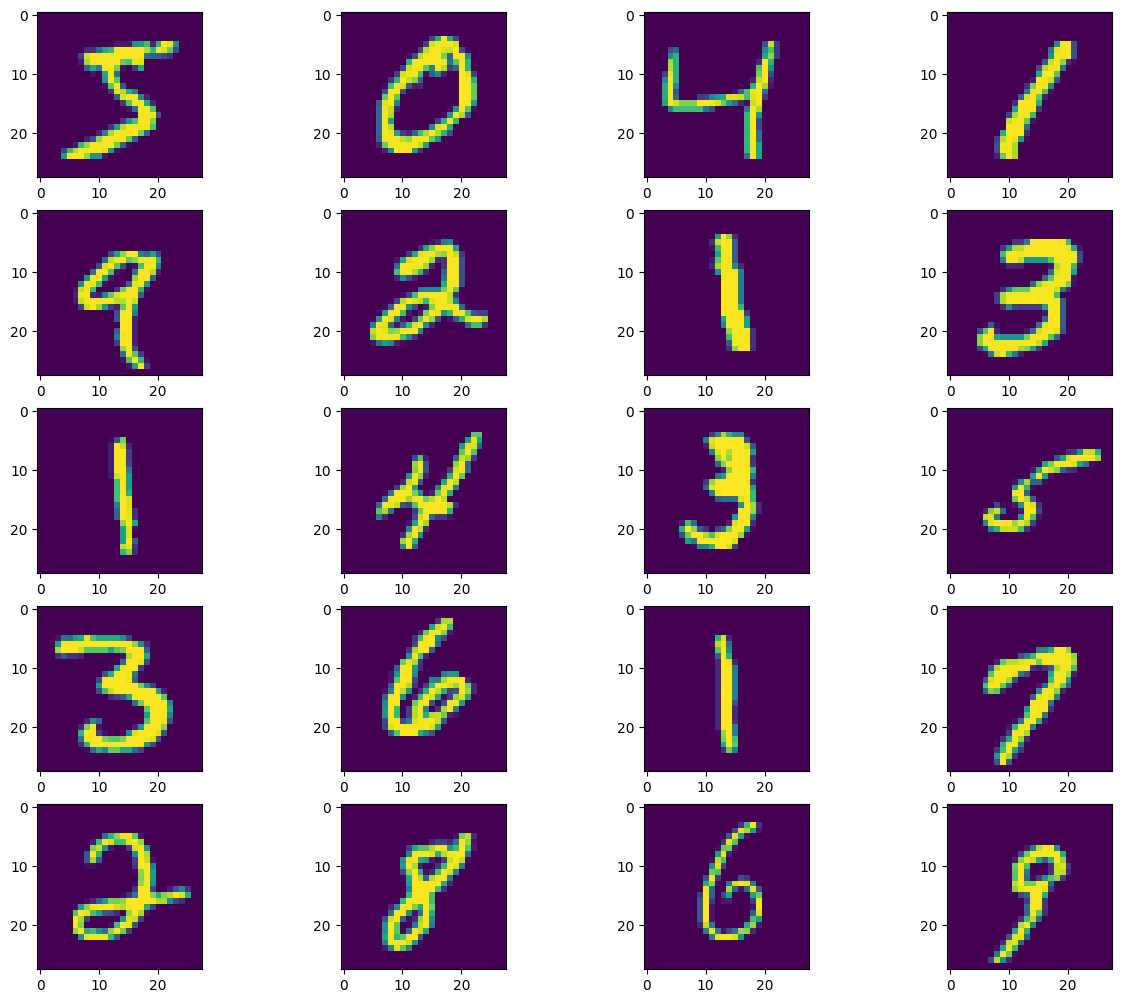

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_images(datset, num_samples=20, cols=4):
    """ Plots some samples from the dataset """
    plt.figure(figsize=(15,15)) 
    for i, img in enumerate(data):
        if i == num_samples:
            break
        plt.subplot(int(num_samples/cols) + 1, cols, i + 1)
        plt.imshow(img[0])

data = torchvision.datasets.MNIST(root=".", download=True)
show_images(data)

In [3]:
print(data.train_data.shape)
print(data.test_data.shape)

torch.Size([60000, 28, 28])
torch.Size([60000, 28, 28])


/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/opt/conda/lib/python3.10/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [4]:
data.train_data[0].shape

torch.Size([28, 28])

# Building the Diffusion Model

## Step 1 The forward process = noise scheduler

We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form provided in the papers to calculate the image for any of the timesteps individually. 

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

In [5]:
import torch.nn.functional as F

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


# Define beta schedule
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

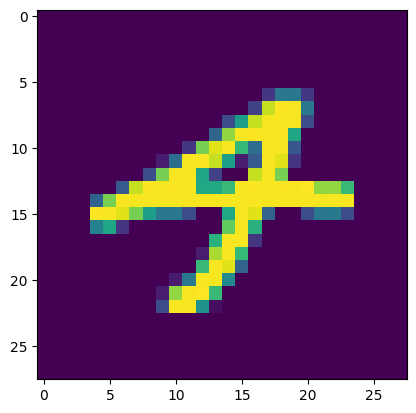

In [6]:
from torchvision import transforms 
import numpy as np
from torch.utils.data import DataLoader, random_split

# IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    # Define the transformations
    data_transform = transforms.Compose([
        # transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # Scales data into [0, 1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ])

    # Load the MNIST datasets
    train_dataset = torchvision.datasets.MNIST(
        root=".", train=True, download=True, transform=data_transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root=".", train=False, download=True, transform=data_transform
    )

    # Optional: split train dataset if you need validation split
    train_size = int(0.7 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

    return train_dataset, val_dataset, test_dataset

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

train_data, val_data, test_data = load_transformed_dataset()
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# Example of displaying an image
for images, labels in train_loader:
    show_tensor_image(images)
    break

/tmp/ipykernel_23/1299770253.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


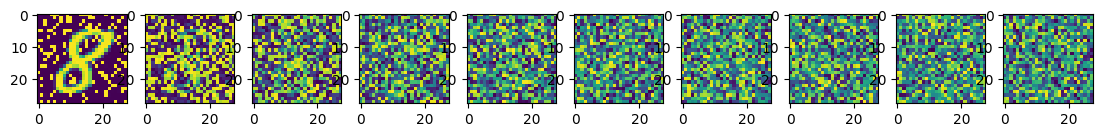

In [7]:
# Simulate forward diffusion
image = next(iter(train_loader))[0]


plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

## Step 2: the backward process = U-net

In [8]:
# from torch import nn
# import math


# class Block(nn.Module):
#     def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
#         super().__init__()
#         self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
#         if up:
#             self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
#             self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
#         else:
#             self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#             self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
#         self.bnorm1 = nn.BatchNorm2d(out_ch)
#         self.bnorm2 = nn.BatchNorm2d(out_ch)
#         self.relu  = nn.ReLU()
        
#     def forward(self, x, t, ):
#         # First Conv
#         h = self.bnorm1(self.relu(self.conv1(x)))
#         # Time embedding
#         time_emb = self.relu(self.time_mlp(t))
#         # Extend last 2 dimensions
#         time_emb = time_emb[(..., ) + (None, ) * 2]
#         # Add time channel
#         h = h + time_emb
#         # Second Conv
#         h = self.bnorm2(self.relu(self.conv2(h)))
#         # Down or Upsample
#         return self.transform(h)


# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         # TODO: Double check the ordering here
#         return embeddings


# class SimpleUnet(nn.Module):
#     """
#     A simplified variant of the Unet architecture.
#     """
#     def __init__(self):
#         super().__init__()
#         image_channels = 1
#         #down_channels = (64, 128, 256, 512, 1024)
#         down_channels = (64, 128, 256, 512)  # Adjusted for 28x28 input to prevent excessive downsampling

#         up_channels = (512, 256, 128, 64)
#         out_dim = 1
#         time_emb_dim = 32

#         # Time embedding
#         self.time_mlp = nn.Sequential(
#                 SinusoidalPositionEmbeddings(time_emb_dim),
#                 nn.Linear(time_emb_dim, time_emb_dim),
#                 nn.ReLU()
#             )
        
#         # Initial projection
#         self.conv0 = nn.Conv2d(image_channels, down_channels[0], 1, padding=1)

#         # Downsample
#         self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
#                                     time_emb_dim) \
#                     for i in range(len(down_channels)-1)])
#         # Upsample
#         self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
#                                         time_emb_dim, up=True) \
#                     for i in range(len(up_channels)-1)])
        
#         # Edit: Corrected a bug found by Jakub C (see YouTube comment)
#         self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

#     def forward(self, x, timestep):
#         # Embedd time
#         t = self.time_mlp(timestep)
#         # Initial conv
#         x = self.conv0(x)
#         # Unet
#         residual_inputs = []
#         for down in self.downs:
#             x = down(x, t)
#             residual_inputs.append(x)
#         for up in self.ups:
#             residual_x = residual_inputs.pop()
#             # Add residual x as additional channels
#             x = torch.cat((x, residual_x), dim=1)           
#             x = up(x, t)
#         return self.output(x)

# model = SimpleUnet()
# print("Num params: ", sum(p.numel() for p in model.parameters()))
# model

In [9]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        
        # Reshape and broadcast time embedding to match h's spatial dimensions
        time_emb = time_emb[..., None, None]
        h = h + time_emb
        
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        
        # Downsample or Upsample
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256)  # Reduced layers to accommodate MNIST's small input size
        up_channels = (256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([
            Block(down_channels[i], down_channels[i+1], time_emb_dim) 
            for i in range(len(down_channels) - 1)
        ])
        
        # Upsample
        self.ups = nn.ModuleList([
            Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) 
            for i in range(len(up_channels) - 1)
        ])
        
        # Output layer
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        
        # Initial convolution
        x = self.conv0(x)
        
        # Downsample path
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        
        # Upsample path
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        
        # Final output layer
        return self.output(x)

# Model instantiation
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  3690721


## Step 3: The loss

In [10]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Sampling

In [11]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        # As pointed out by Luis Pereira (see YouTube comment)
        # The t's are offset from the t's in the paper
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image():
    # Sample noise
#     img_size = IMG_SIZE
    img = torch.randn((1, 1, 28, 28), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        # Edit: This is to maintain the natural range of the distribution
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()            

## Training

Epoch 0 | step 000 Loss: 0.8042913675308228 


/tmp/ipykernel_23/1738267838.py:44: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images, int(i/stepsize)+1)


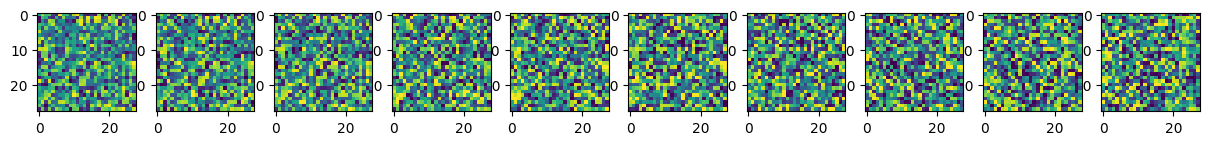

Epoch 5 | step 000 Loss: 0.0944669246673584 


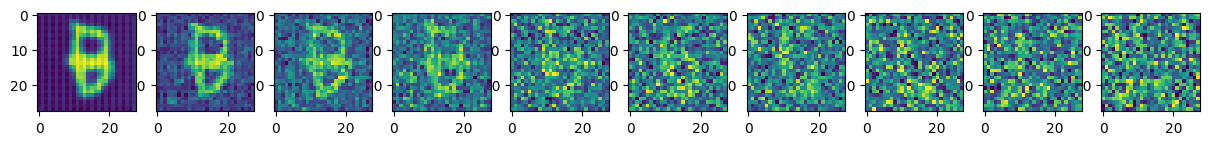

Epoch 10 | step 000 Loss: 0.08369620889425278 


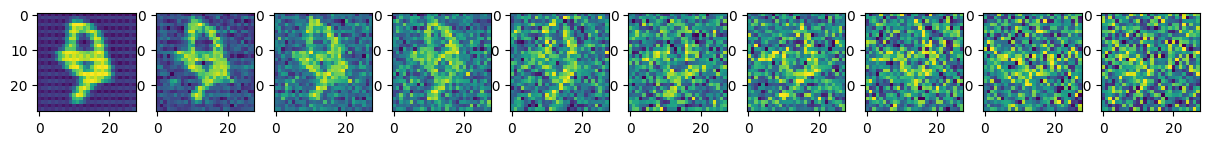

Epoch 15 | step 000 Loss: 0.08690819889307022 


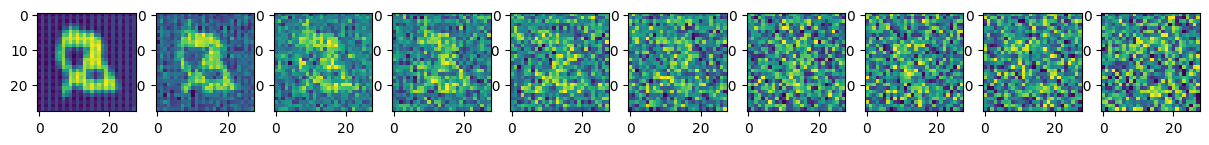

Epoch 20 | step 000 Loss: 0.08260734379291534 


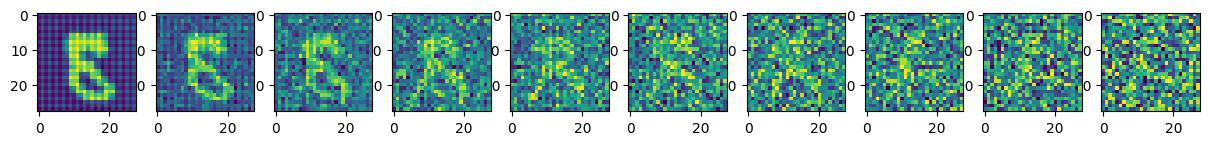

Epoch 25 | step 000 Loss: 0.08158808201551437 


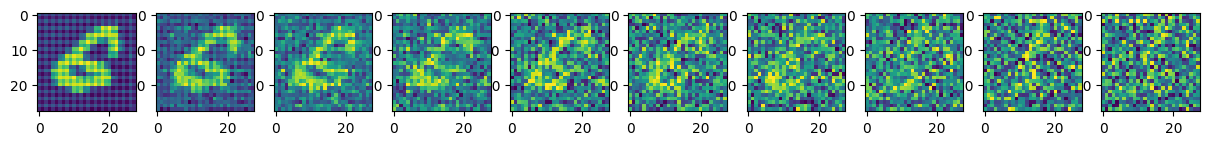

Epoch 30 | step 000 Loss: 0.07430152595043182 


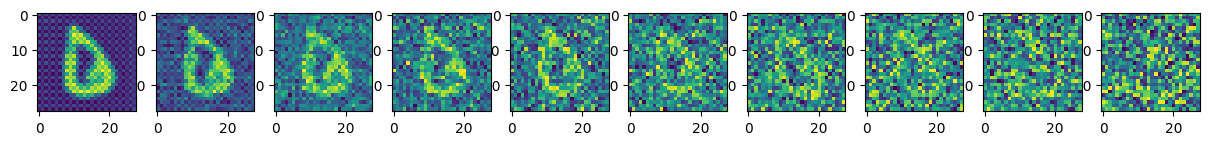

Epoch 35 | step 000 Loss: 0.07801961898803711 


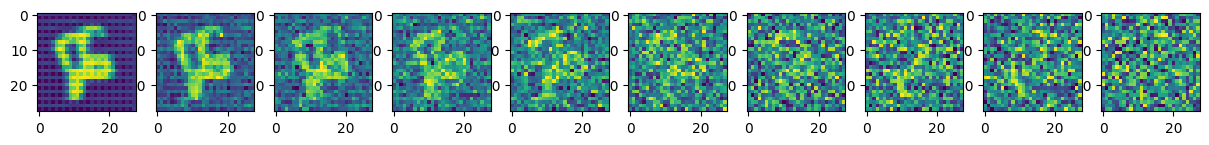

Epoch 40 | step 000 Loss: 0.08031505346298218 


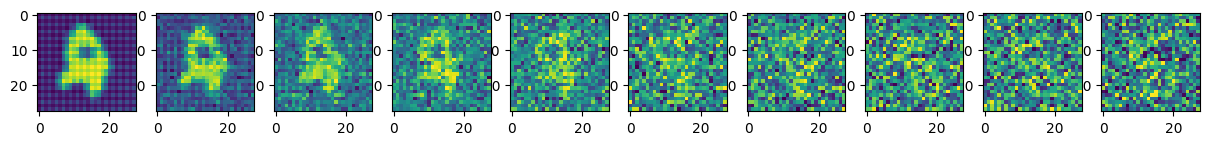

Epoch 45 | step 000 Loss: 0.07583781331777573 


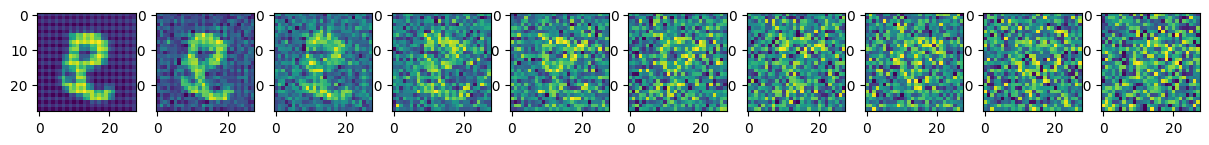

Epoch 50 | step 000 Loss: 0.07478968054056168 


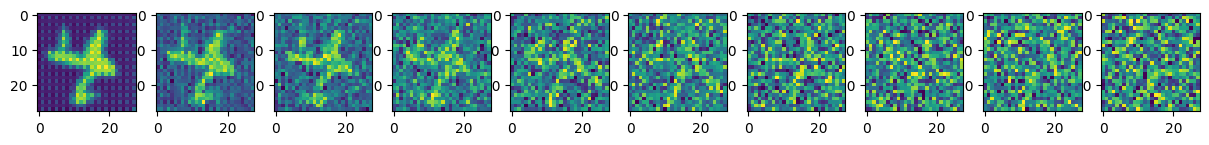

Epoch 55 | step 000 Loss: 0.07962027937173843 


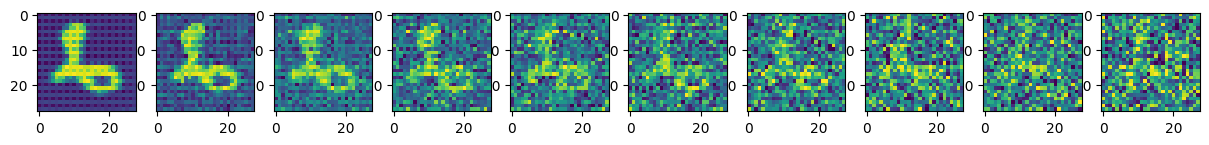

Epoch 60 | step 000 Loss: 0.07478631287813187 


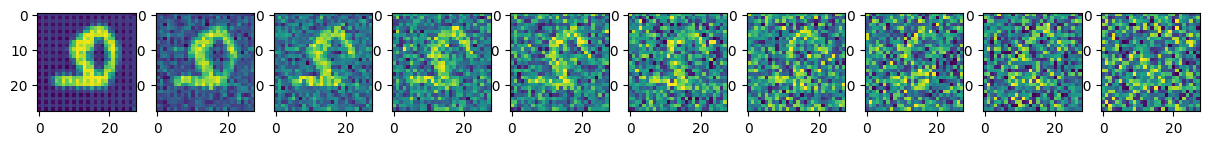

Epoch 65 | step 000 Loss: 0.07374097406864166 


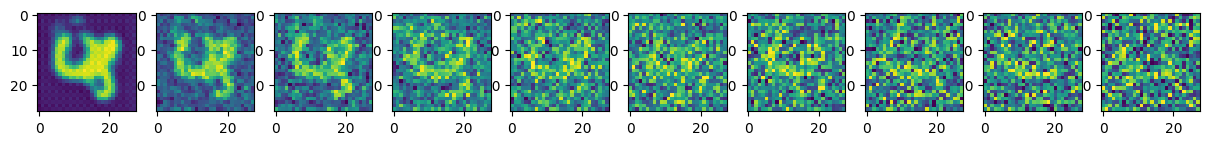

Epoch 70 | step 000 Loss: 0.07192470133304596 


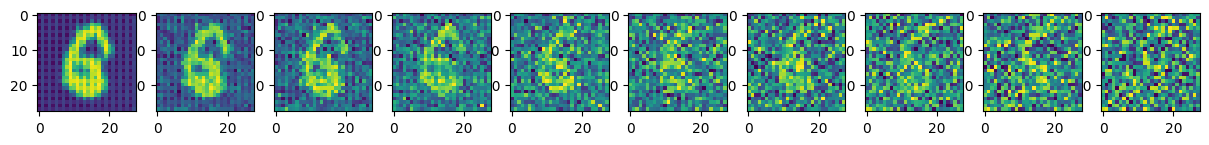

Epoch 75 | step 000 Loss: 0.07039467245340347 


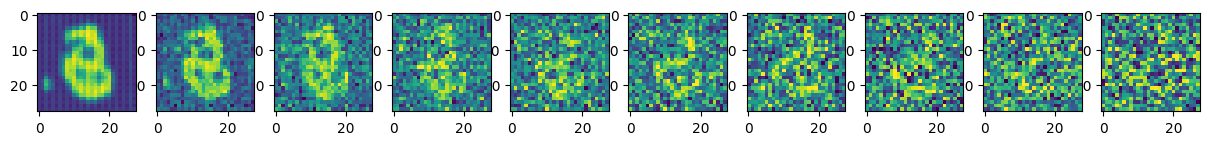

Epoch 80 | step 000 Loss: 0.0780496820807457 


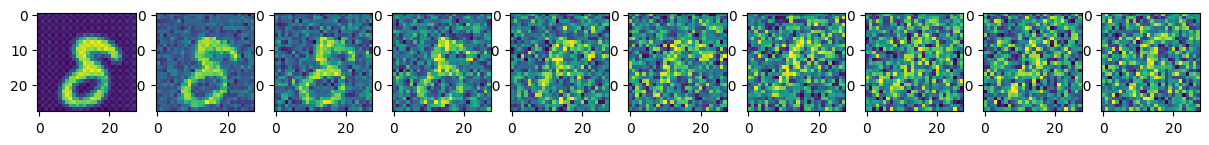

Epoch 85 | step 000 Loss: 0.07355553656816483 


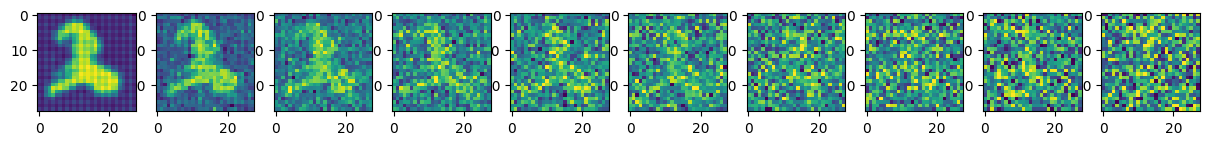

Epoch 90 | step 000 Loss: 0.06797622889280319 


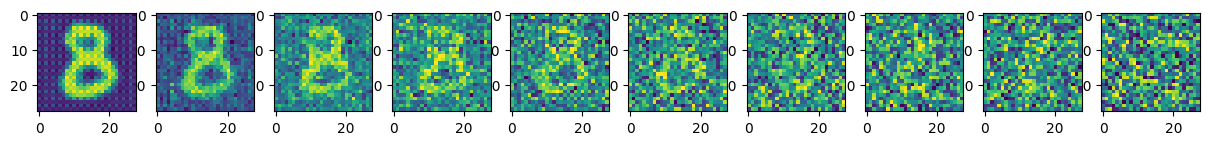

Epoch 95 | step 000 Loss: 0.07702258229255676 


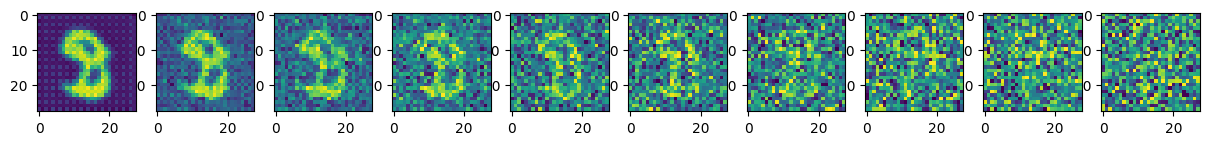

Model saved to /kaggle/working/diffusion_model.pth


In [12]:
from torch.optim import Adam
import math

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100

for epoch in range(epochs):
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Random timesteps for diffusion
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        
        # Compute loss and backpropagate
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()
        
        # Print status
        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()

# Save the model and optimizer states
save_path = "/kaggle/working/diffusion_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epochs,
}, save_path)
print(f"Model saved to {save_path}")

In [13]:
# Initialize model and optimizer
model = SimpleUnet().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

# Load the model and optimizer states
checkpoint = torch.load("diffusion_model.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

print(f"Model loaded from epoch {start_epoch}")

Model loaded from epoch 100


/tmp/ipykernel_23/4085880780.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("diffusion_model.pth", map_location=device)


# Testing the code for random images 

In [14]:
@torch.no_grad()
def sample_images(model, sample_size, T, img_shape=(1, 28, 28)):
    """
    Generates and visualizes images from the trained diffusion model.
    
    Parameters:
        model (torch.nn.Module): The trained diffusion model.
        sample_size (int): Number of images to sample.
        T (int): Number of diffusion steps (same as in training).
        img_shape (tuple): Shape of each generated image (default is 28x28 for MNIST).
    
    Returns:
        List of generated images.
    """
    # Initialize random noise as starting point
    x = torch.randn((sample_size, *img_shape)).to(device)
    
    # Iteratively reverse the diffusion process
    for t in reversed(range(T)):
        # Create time tensor
        time_tensor = torch.tensor([t] * sample_size, device=device).long()
        
        # Predict and apply denoising step (assuming function 'predict_noise' exists)
        noise_pred = model(x, time_tensor)
        
        # Denoise x_t to x_t-1 (may involve some noise addition based on your training)
        x = x - noise_pred  # Example step, modify based on your model's structure
    
    # Transform tensor images back to a plottable form
    generated_images = (x + 1) / 2  # Rescale to [0, 1] range
    
    # Plot generated images
    plt.figure(figsize=(10, 10))
    for i in range(sample_size):
        plt.subplot(1, sample_size, i + 1)
        plt.imshow(generated_images[i].cpu().squeeze(), cmap="gray")
        plt.axis('off')
    plt.show()

    return generated_images

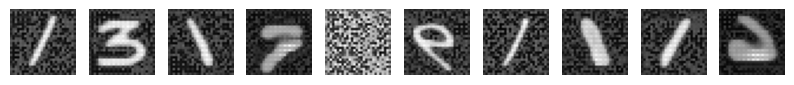

In [15]:
sample_size = 10  # Number of images to sample
generated_images = sample_images(model, sample_size, T=T, img_shape=(1, 28, 28))